# Claisificación de Residuos con Transfer Learning DenseNet169

**Nombre:** Leobardo García Reyes

**Matrícula:** 1616825

## Conectar con Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerías

In [2]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 7.6 MB/s 


In [3]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import matplotlib.image as mpimg
import matplotlib.image as img
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
from PIL import ImageFont
import cv2
from time import time
from datetime import datetime
from statistics import mean

In [4]:
# Importar los paquetes de keras y tensorflow
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import (Dense, Dropout, Conv2D, Flatten, AveragePooling2D, BatchNormalization,
                          Activation, MaxPooling2D, ZeroPadding2D)
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_recall_curve, recall_score, precision_score
from mlxtend.plotting import plot_confusion_matrix
from IPython.core.pylabtools import figsize
from keras.utils.metrics_utils import ConfusionMatrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.utils.vis_utils import plot_model
import visualkeras
from collections import defaultdict

from keras.applications.densenet import DenseNet169

## Datos

### Lectura de datos

In [5]:
direccion_entrenamiento = '/content/drive/MyDrive/Tarea 6/DATASET/TRAIN'
direccion_prueba = '/content/drive/MyDrive/Tarea 6/DATASET/TEST'

### Conteo de la base de datos

Se cuenta con una base de datos de 25077 imágenes. Para el conjunto de entrenamiento se tiene 22564, dividido en Orgánico con 12565 y Reciclable con 9999 imágenes. Para el conjunto de prueba se tiene 2513, dividido en Orgánico con 1401 y Reciclable con 1112 imágenes.

In [6]:
def conteo_datos(direccion_archivo):
    conteo_clase = {}
    conteo_total = 0
    if 'pred' in direccion_archivo:
        return len(os.listdir(os.path.join(direccion_archivo))), conteo_clase
    else:
        for nombre_clase in os.listdir(os.path.join(direccion_archivo)):
            conteo = len(os.listdir(os.path.join(direccion_archivo, nombre_clase)))
            conteo_clase[nombre_clase] = conteo
            conteo_total += conteo
    return conteo_total, conteo_clase

In [7]:
conteo_entrenamiento, conteo_clase_entrenamiento = conteo_datos(direccion_entrenamiento)
conteo_prueba, conteo_clase_prueba = conteo_datos(direccion_prueba)

print('Tamaño de datos de entrenamineto: ', conteo_entrenamiento, conteo_clase_entrenamiento)
print('Tamaño de datos de entrenamineto: ', conteo_prueba, conteo_clase_prueba)

Tamaño de datos de entrenamineto:  22564 {'O': 12565, 'R': 9999}
Tamaño de datos de entrenamineto:  2513 {'O': 1401, 'R': 1112}


### Vista gráfica de las dos clases

Aquí se generó una vista de lo que contiene las dos clases.

In [8]:
# Guarda la dirección de la primera imagen de cada categría
etiquetas_imagenes = ['Organico', 'Reciclable']
carpeta = os.listdir(direccion_entrenamiento)

guardar_ima = []

for i in carpeta:
  aux = '/' + i
  aux2 = os.listdir(direccion_entrenamiento + aux)[0]
  aux3 = aux + '/'
  aux4 = aux3 + aux2
  aux5 = direccion_entrenamiento + aux4
  guardar_ima.append(aux5)

guardar_ima

['/content/drive/MyDrive/Tarea 6/DATASET/TRAIN/O/O_8505.jpg',
 '/content/drive/MyDrive/Tarea 6/DATASET/TRAIN/R/R_9755.jpg']

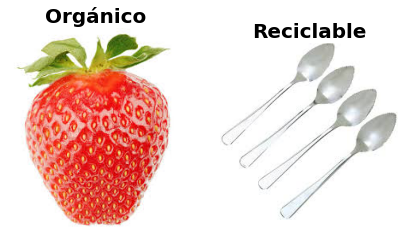

In [9]:
# Mostrar la primera imagen de cada categría
# Gráficar una imagen Orgánica y Reciclable
Organico = direccion_entrenamiento + '/O/O_1.jpg'
Organico2 = imread(Organico)
Reciclable = direccion_entrenamiento + '/R/R_9411.jpg'
Reciclable2 = imread(Reciclable)

Imagenes = [Organico2, Reciclable2]
Etiquetas_imagenes = ['Orgánico', 'Reciclable']

for i in range(2):
    plt.figure(1, figsize = (7, 5))
    plt.subplot(1, 2, i + 1)
    plt.title(Etiquetas_imagenes[i], fontweight = 'bold', fontsize = 20)
    plt.imshow(Imagenes[i])
    plt.axis('off')

plt.show()

### Dimensiones de las imágenes

In [10]:
# Checar dimensiones
ancho1 = []
alto1 = []

subcarpetas = ['/O', '/R']
carpeta = os.listdir(direccion_entrenamiento)

for i in subcarpetas:
  for j in os.listdir(direccion_entrenamiento + i):
    aux = direccion_entrenamiento + i
    aux2 = aux + '/'
    img = Image.open(aux2 + j)
    ancho, alto = img.size
    ancho1.append(ancho)
    alto1.append(alto)

print(mean(ancho1))
print(mean(alto1))

252.31687644034744
203.74711930508775


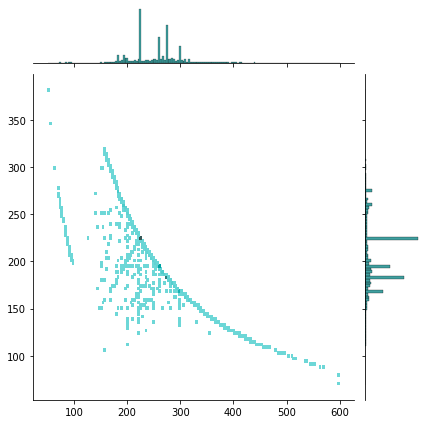

In [11]:
sns.jointplot(x = ancho1, y = alto1, kind = 'hist', color = 'teal')

### Pre-procesamiento de imágenes

Lo que se busca aquí, es aplicarle un preprocesamiento a las imágenes y también aumentar la cantidad de imágenes que se disponen para tener más variedad.

- El rescale, sirve para pasar los pixeles de [0, 255] a [0, 1]. Esto sirve para tratar todas las imágenes de la misma manera.

- El horizontal_flip, sirve para voltear las imágenes horizontalmente aleatoriamente.

- El vertical_flip, sirve para voltear las imágenes verticalmente aleatoriamente.

In [12]:
Nuevas_imagenes_entrenamineto = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                   horizontal_flip = True, # Voltea aleatoriamente las imágenes horizontalmente
                                                   vertical_flip = True, # Voltea aleatoriamente las imágenes verticalmente
                                                   #rotation_range = 20, # Rotación aleatoria
                                                   #zoom_range = 0.1 # Zoom aleatorio
                                                   )

Nuevas_imagenes_validacion = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                validation_split = 0.4 # 40% de imágenes a validación
                                                )


Nuevas_imagenes_prueba = ImageDataGenerator(rescale = 1/255 # Normaliza las imágenes
                                            )

### Aplicando el preprocesamiento

Aquí se aplica a todas las imágenes lo que se estableció en la parte anterior. Adicionalmente: 

- Se reescala el tamaño de las imágenes para que todas tengan el mismo tamaño.

- Se establece el tamaño de lote (batch size), es la cantidad de muestras de entrenamiento que se usa en un pase hacia adelante y un pase hacia atrás.

- El class_mode, es el tipo de variable que se esta manejando, es decir, si son 2 clases es de tipo binario. Si es más de 2 clases, entonces es categórico.

- El color_mode, es la cantidad de canales que tendrán las imágenes, es decir, escala de grises, RGB o RGBA.

- El shuffle, es para mezclar las imágenes. En el conjunto de entrenamiento se estableció en True y en los demás en False. Esto se debe, ya que al momento de evaluar el modelo no lograba distinguir entre clases. Se le atribuye a una varianza inter grupo.

- El classes, es para establecerle nombres a las clases.

In [13]:
# Cambiando aleatoriamente las imágenes
altura = 400
ancho = 400
batch_size = 16

Entrenamiento = Nuevas_imagenes_entrenamineto.flow_from_directory(direccion_entrenamiento, # Carpeta donde se encuentran las imágenes
                                                                  target_size = (altura, ancho), # Reescalando el tamaño de las imágenes
                                                                  batch_size = batch_size, # Tamaño del batch size
                                                                  class_mode = 'binary', # Tipo de variable
                                                                  color_mode = 'rgb', # Canal de la imagen
                                                                  shuffle = True, # Mezclar las imágenes
                                                                  classes = ['O', 'R'] # Etiqueta de las clases
                                                                  )

Validacion = Nuevas_imagenes_validacion.flow_from_directory(direccion_entrenamiento, # Carpeta donde se encuentran las imágenes
                                                            target_size = (altura, ancho), # Reescalando el tamaño de las imágenes
                                                            batch_size = batch_size, # Tamaño del batch size
                                                            class_mode = 'binary', # Tipo de variable
                                                            color_mode = 'rgb', # Canal de la imagen
                                                            shuffle = False, # Mezclar las imágenes
                                                            subset = 'validation', # Imágenes de validación
                                                            classes = ['O', 'R'] # Etiqueta de las clases
                                                            )

Prueba = Nuevas_imagenes_prueba.flow_from_directory(direccion_prueba, # Carpeta donde se encuentran las imágenes
                                                    target_size = (altura, ancho), # Reescalando el tamaño de las imágenes
                                                    batch_size = batch_size, # Tamaño del batch size
                                                    class_mode = 'binary', # Tipo de variable
                                                    color_mode = 'rgb', # Canal de la imagen
                                                    shuffle = False, # Mezclar las imágenes
                                                    classes = ['O', 'R'] # Etiqueta de las clases
                                                    )

# Este solo es para realizar predicciones y graficar
Prueba2 = Nuevas_imagenes_prueba.flow_from_directory(direccion_prueba, # Carpeta donde se encuentran las imágenes
                                                    target_size = (altura, ancho), # Reescalando el tamaño de las imágenes
                                                    batch_size = batch_size, # Tamaño del batch size
                                                    class_mode = 'binary', # Tipo de variable
                                                    color_mode = 'rgb', # Canal de la imagen
                                                    shuffle = True, # Mezclar las imágenes
                                                    classes = ['O', 'R'] # Etiqueta de las clases
                                                    )

Found 22564 images belonging to 2 classes.
Found 9025 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


### Ejemplo de transformación de imágenes

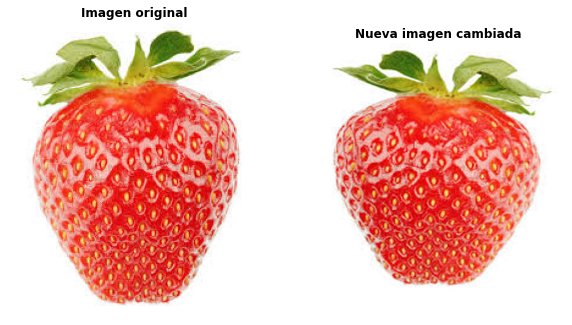

In [40]:
# Gráficar la imagen original con una imagen cambiada aleatoriamente
Organico3 = cv2.imread(direccion_entrenamiento + '/O/O_1.jpg')
res = cv2.resize(Organico3, dsize=(altura, ancho), interpolation=cv2.INTER_CUBIC)

Imagenes2 = [Organico3, Nuevas_imagenes_entrenamineto.random_transform(res)]
Clases = ['Imagen original', 'Nueva imagen cambiada']

for i in range(2):
    plt.figure(1, figsize = (10, 10))
    plt.subplot(1, 2, i + 1) 
    plt.title(Clases[i], fontweight = 'bold') 
    plt.imshow(cv2.cvtColor(Imagenes2[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.show()

## Modelo

### Arquitectura del modelo

Para la arquitectura del modelo se utilizará DenseNet169 con los pesos de la base de datos "Imagenet".

In [15]:
# Construcción del modelo
modelo = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (altura, ancho, 3))

51888128/51877672 [==============================] - 0s 0us/step


In [16]:
#for layer in modelo.layers:
#  layer.trainable = False
  
# Make sure you have frozen the correct layers
#for i, layer in enumerate(modelo.layers):
#  print(i, layer.name, layer.trainable)

In [17]:
modelo2 = Sequential()
modelo2.add(modelo)
modelo2.add(Flatten())
modelo2.add(Dense(1))
modelo2.add(Activation('sigmoid'))

### Métricas, función de pérdida y optimizador

Como métricas se utilizó:

- Accuracy (Exactitud): Es la proporción de resultados verdaderos (Verdaderos Positivos como Verdaderos Negativos) dividido entre el número total de casos examinados (Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos, Falsos Negativos). Sin embargo, una de sus desventajas es que no funciona bien con clases desequilibradas.

- Precision (Precisión): Es la proporción de Verdaderos Positivos dividido entre los identificados como positivos (Verdaderos Positivos y Falsos Positivos). Sin embargo, una de sus desventajas es que no funciona bien con clases desequilibradas.

- Recall (Sensibilidad): Es la proporción de Verdaderos Positivos que fueron correctamente identificados por el algoritmo entre el total de Verdaderos Positivos (Verdaderos Positivos y Falsos Negativos). Representa la fracción de Verdaderos Positivos.

- Specificidad (Especificidad): Es la proporción de Verdaderos Negativos que fueron correctamente identificados por el algoritmo entre el total de Verdaderos Negativos (Verdaderos Negativos y Falsos Positivos). Representa la fracción de Verdaderos Negativos.

- F1 Score (Puntaje F1): Asume que nos importa de igual forma la precisión y la exhaustividad.

- AUC (Area Bajo la Curva): Este puntaje nos da una buena idea de que tan bien funciona el modelo.

Por otra parte, como función de perdida se utilizó la entropía cruzada binaria, ya que penaliza la probabilidad en función de que tan lejos esta del valor esperado real. La penalización es de naturaleza logarítmica, lo que genera una puntuación grande para las diferencias grandes cercanas a 1 y una puntuación pequeña para las diferencias pequeñas que tienden a 0. Y por ultimo, como optimizador se utilizó el
optimizador de Adam como alternativa para compararlo con el SGD y probar si obtenían buenos resultados.

In [18]:
# Métricas
metricas = [tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy'),
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall'),
            tf.keras.metrics.AUC(name = 'auc')]

# Función de perdida y el optimizador
modelo2.compile(loss = tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'),
                optimizer = 'adam',
                metrics = metricas)

In [19]:
# Resumen del modelo VGG16
modelo.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 406, 406, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 200, 200, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [20]:
# Resumen del modelo final
modelo2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 12, 12, 1664)      12642880  
                                                                 
 flatten (Flatten)           (None, 239616)            0         
                                                                 
 dense (Dense)               (None, 1)                 239617    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 12,882,497
Trainable params: 12,724,097
Non-trainable params: 158,400
_________________________________________________________________


### Visualización del modelo

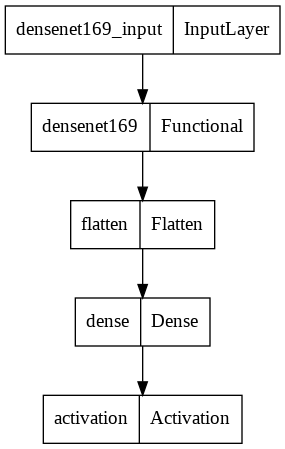

In [21]:
plot_model(modelo2, to_file = '/content/drive/MyDrive/Tarea 6/modelo_1_DenseNet169.png')

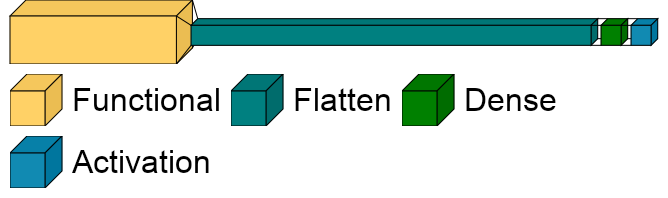

In [22]:
#https://github.com/paulgavrikov/visualkeras/

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(modelo2, to_file = '/content/drive/MyDrive/Tarea 6/modelo_1v2_DenseNet169.png').show()
font = ImageFont.truetype('/content/drive/MyDrive/Tarea 6/arial.ttf', 32)
visualkeras.layered_view(modelo2, legend = True, font = font, color_map = color_map)

In [23]:
# ESTE SE HACE EN MI PC
# https://github.com/lutzroeder/Netron

### Entrenamiento del modelo

- Se añadió una función para reducir la tasa de aprendizaje cuando una métrica ha dejado de mejorar.

- Se añadió una función para dejar de entrenar el modelo cuando una métrica monitoreada haya
dejado de mejorar.

In [24]:
# Entrener el modelo
Inicio = time()

reducir_ta = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1,
                               min_lr = 1e-5, mode = 'min')
parar_modelo = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, min_delta = 1e-5,
                             mode='min')
callbacks_lista = [parar_modelo, reducir_ta]

ksst = modelo2.fit(Entrenamiento, epochs = 40, validation_data = Validacion, callbacks = callbacks_lista)

Final = time()
Tiempo_total = Final - Inicio

print('\nTiempo de entrenamiento: {:.0f}h {:.0f}m {:.0f}s.'.format(Tiempo_total // (60 * 60),
                                                                   Tiempo_total // 60,
                                                                   Tiempo_total % 60))

Epoch 1/40
1411/1411 [==============================] - 585s 393ms/step - loss: 2.7212 - binary_accuracy: 0.7209 - precision: 0.6859 - recall: 0.6829 - auc: 0.7658 - val_loss: 0.8872 - val_binary_accuracy: 0.7754 - val_precision: 0.6804 - val_recall: 0.9300 - val_auc: 0.8871 - lr: 0.0010
Epoch 2/40
1411/1411 [==============================] - 546s 387ms/step - loss: 1.2557 - binary_accuracy: 0.7425 - precision: 0.7108 - recall: 0.7063 - auc: 0.7954 - val_loss: 0.6062 - val_binary_accuracy: 0.7744 - val_precision: 0.6923 - val_recall: 0.8835 - val_auc: 0.8746 - lr: 0.0010
Epoch 3/40
1411/1411 [==============================] - 546s 387ms/step - loss: 0.5086 - binary_accuracy: 0.8009 - precision: 0.7750 - recall: 0.7761 - auc: 0.8696 - val_loss: 3.5000 - val_binary_accuracy: 0.8393 - val_precision: 0.8365 - val_recall: 0.7922 - val_auc: 0.9013 - lr: 0.0010
Epoch 4/40
1411/1411 [==============================] - 546s 387ms/step - loss: 0.4224 - binary_accuracy: 0.8233 - precision: 0.8026 

### Gráficos de entrenamiento y validación del modelo

Se puede observar que tiene un muy buenos resultados los datos de entrenamiento y de validación.

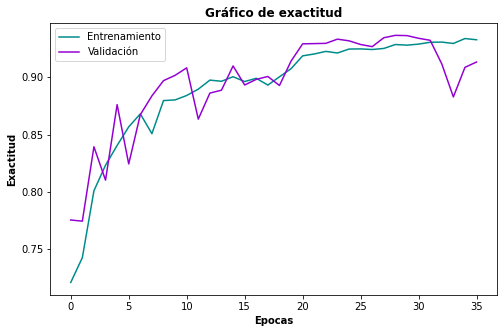

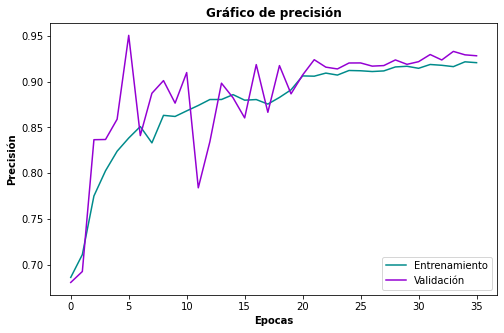

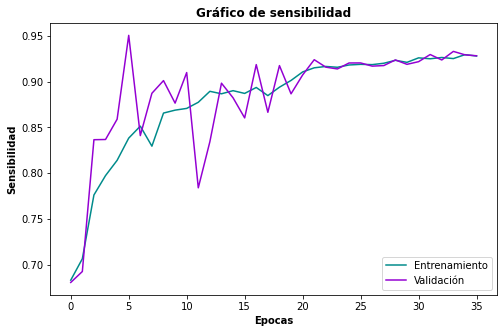

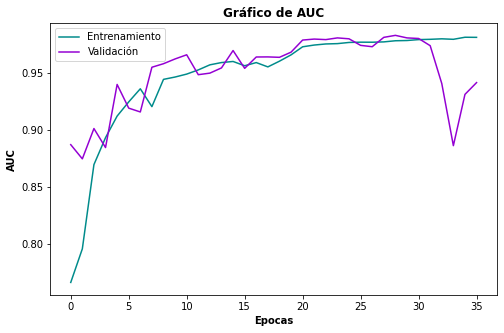

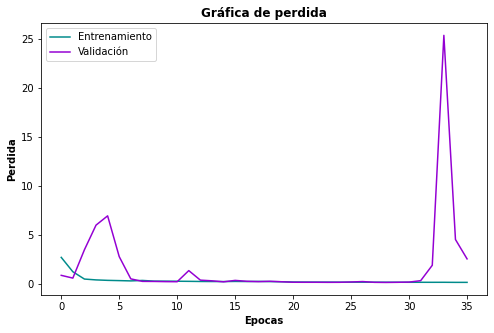

In [25]:
Epocas = range(len(ksst.history['binary_accuracy']))

# Gráfico de accuracy
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['binary_accuracy'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_binary_accuracy'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Exactitud', fontweight = 'bold')
plt.title('Gráfico de exactitud', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de precision
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['precision'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Precisión', fontweight = 'bold')
plt.title('Gráfico de precisión', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de recall
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['recall'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Sensibilidad', fontweight = 'bold')
plt.title('Gráfico de sensibilidad', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de auc
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['auc'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_auc'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('AUC', fontweight = 'bold')
plt.title('Gráfico de AUC', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfica de loss
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['loss'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_loss'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Perdida', fontweight = 'bold')
plt.title('Gráfica de perdida', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

### Evaluación del modelo

Se puede observar que tiene un muy buenos resultados en cada una de las métricas.

In [26]:
# Evaluación del modelo
# https://stackoverflow.com/questions/63684459/should-i-use-evaluate-generator-or-evaluate-to-evaluate-my-cnn-model
# Se debe usar .fit y .evaluate, porque .fit_generator y .evaluate_generator estan obsoletos
Evaluacion_modelo = modelo2.evaluate(Prueba)
Evaluacion_modelo

158/158 [==============================] - 688s 4s/step - loss: 5.0747 - binary_accuracy: 0.9017 - precision: 0.9519 - recall: 0.8192 - auc: 0.9438


[5.074734210968018,
 0.901711106300354,
 0.9519331455230713,
 0.8192446231842041,
 0.9437696933746338]

In [ ]:
print(f'Exactitud del conjunto de prueba: {Evaluacion_modelo[1]*100:.2f}%\n')
print(f'Presición del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Sensibilidad del conjunto de prueba: {Evaluacion_modelo[3]*100:.2f}%\n')
print(f'Área bajo la curva del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Perdida del conjunto de prueba: {Evaluacion_modelo[0]*100:.2f}%')

### Predicciones del modelo

In [ ]:
# Predecir del conjunto del prueba
# Se usa .predict para predecir
Predecir = modelo2.predict(Prueba)
Predecir

In [29]:
# Etiqueta de las clases
Entrenamiento.class_indices

{'O': 0, 'R': 1}

In [ ]:
# Etiquetas del conjunto de prueba
Prueba.classes

In [ ]:
# Clasificación de acuerdo al umbral de 0.5
Clasificacion = Predecir > 0.5
Clasificacion

### Curva ROC AUC

La curva ROC obtenida, nos esta diciendo que es muy bueno el modelo distinguiendo entre dos clases.

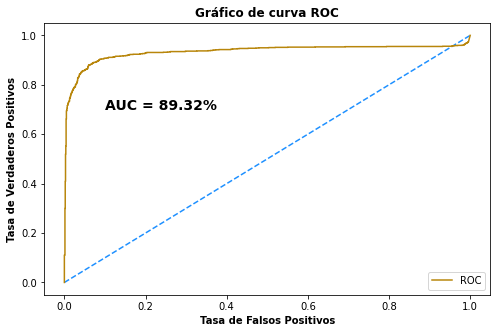

In [32]:
# Gráfico de la curva ROC
ns_probs = [0 for _ in range(len(Prueba.classes))]

ns_fpr, ns_tpr, _ = roc_curve(Prueba.classes, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Prueba.classes, Predecir)
plt.figure(figsize = (8, 5))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color = 'dodgerblue')
plt.plot(lr_fpr, lr_tpr, label = 'ROC', color = 'darkgoldenrod')
plt.xlabel('Tasa de Falsos Positivos', fontweight = 'bold')
plt.ylabel('Tasa de Verdaderos Positivos', fontweight = 'bold')
plt.text(0.1, 0.7, f'AUC = {roc_auc_score(Prueba.classes, Clasificacion)*100:.2f}%', fontsize = 14, fontweight = 'bold')
plt.title('Gráfico de curva ROC', fontweight = 'bold')
plt.legend(loc = 4)
plt.show()

In [33]:
# Reporte de clasificación
Etiquetas_imagenes = ['Orgánico', 'Reciclable']

print('Reporte de clasificación:')
print(classification_report(y_true = Prueba.classes, y_pred = Clasificacion,
                            target_names = Etiquetas_imagenes))

Reporte de clasificación:
              precision    recall  f1-score   support

    Orgánico       0.87      0.97      0.92      1401
  Reciclable       0.95      0.82      0.88      1112

    accuracy                           0.90      2513
   macro avg       0.91      0.89      0.90      2513
weighted avg       0.91      0.90      0.90      2513



### Matriz de confusión

Como se puede ver en la matriz de confusión, el modelo se equivoca más cuando trata de predecir materiales Reciclables y los clasifica como Orgánicos.

Índices: {'O': 0, 'R': 1} 

Matriz de confusión:
[[1355   46]
 [ 201  911]] 



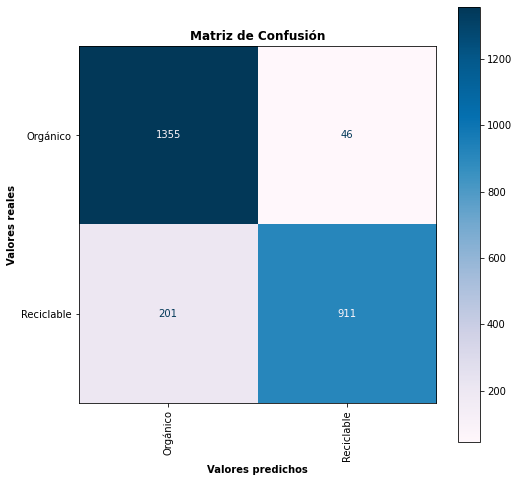



Exactitud: 90.17%

Presición: 95.19%

Sensibilidad: 81.92%

Puntaje F1: 88.06%

Área bajo la curva: 89.32%



In [34]:
# Construcción de matriz de confusión y reporte de clasificación
print('Índices:', Entrenamiento.class_indices, '\n')

matriz = confusion_matrix(y_true = Prueba.classes, y_pred = Clasificacion)

print('Matriz de confusión:')
print(matriz, '\n')

disp = ConfusionMatrixDisplay(confusion_matrix = matriz,
                              display_labels = Etiquetas_imagenes)
fig, ax = plt.subplots(figsize = (8, 8))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'PuBu')
plt.title('Matriz de Confusión', fontweight = 'bold')
plt.xlabel('Valores predichos', fontweight = 'bold')
plt.ylabel('Valores reales', fontweight = 'bold')
plt.show()

print('\n')
print(f'Exactitud: {accuracy_score(Prueba.classes, Clasificacion)*100:.2f}%\n')
print(f'Presición: {precision_score(Prueba.classes, Clasificacion)*100:.2f}%\n')
print(f'Sensibilidad: {recall_score(Prueba.classes, Clasificacion)*100:.2f}%\n')
print(f'Puntaje F1: {f1_score(Prueba.classes, Clasificacion)*100:.2f}%\n')
print(f'Área bajo la curva: {roc_auc_score(Prueba.classes, Clasificacion)*100:.2f}%\n')

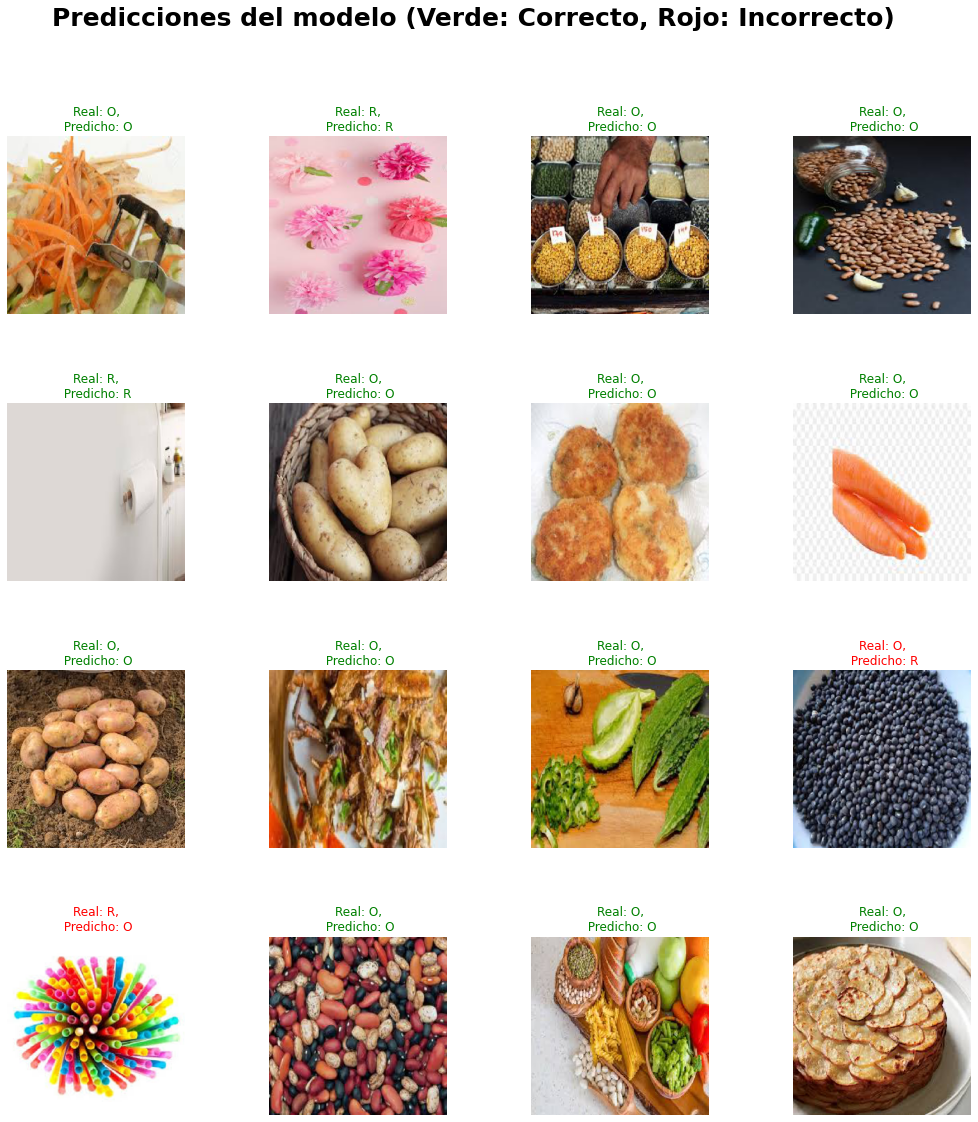

In [35]:
test_x, test_y = next(iter(Prueba2))

labels = (Prueba2.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds = modelo2.predict(test_x)

binario = []
for i in range(len(preds)):
    aux = 1 if preds[i] > 0.5 else 0
    binario.append(aux)

categoria_predicha = []
categoria_real = []
for j in range(len(preds)):
    aux2 = 'O' if binario[j] == 0 else 'R'
    categoria_predicha.append(aux2)
    aux3 = 'O' if test_y[j] == 0 else 'R'
    categoria_real.append(aux3)

plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace = 0.5)
for n in range(len(preds)):
    plt.subplot(4, 4, n + 1)
    plt.imshow(test_x[n])
    color = 'green' if test_y[n] == binario[n] else 'red'
    plt.title(f"Real: {categoria_real[n]},\n Predicho: {categoria_predicha[n]}",
            color = color)
    plt.axis('off')
    _ = plt.suptitle('Predicciones del modelo (Verde: Correcto, Rojo: Incorrecto)', fontweight = 'bold', fontsize = 25)

### Guardado del modelo

In [36]:
# ANTES DE CORRER ESTA LINEA, ASEGURESE DE NO TENER EL MODELO GUARDADO ANTERIORMENTE

# Guardar el modelo
modelo2.save('/content/drive/MyDrive/Tarea 6/Modelo_Residuos_DenseNet169.h5')
modelo2.save('Modelo_Residuos_DenseNet169.h5')

# Guardar los pesos del modelo
modelo2.save_weights('/content/drive/MyDrive/Tarea 6/Modelo_Pesos_Residuos_DenseNet169.h5')

## Pruebas para pasar el modelo a js

In [37]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.3 MB/s 
     |████████████████████████████████| 40 kB 7.5 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!mkdir carpeta_salida

In [39]:
!tensorflowjs_converter --input_format keras Modelo_Residuos_DenseNet169.h5 carpeta_salida